In [376]:
from glob import glob
import numpy as np
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext
import torch

from utils import tokenizer_with_preprocessing
from trainer import Trainer

LOG_DIR = os.path.join('.', 'logs')
NEWS_PATH = os.path.join('..', 'data', 'news')

In [397]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_length', type=int, default=1000)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--n_epochs', type=int, default=100)
parser.add_argument('--target_update_freq', type=int, default=100)
parser.add_argument('--evaluation_freq', type=int, default=10)
parser.add_argument('--network_save_freq', type=int, default=10)
parser.add_argument('--num_actions', type=int, default=1)

parser.add_argument('--min_freq', type=int, default=10)
parser.add_argument('--embedding_dim', type=int, default=300)
parser.add_argument('--n_filters', type=int, default=100)
parser.add_argument('--filter_sizes', type=list, default=[3, 4, 5])
parser.add_argument('--pad_idx', type=list, default=1)
parser.add_argument('--gamma', type=float, default=0.97)
parser.add_argument('--learning_rate', type=float, default=2.5e-4)

parser.add_argument('--test', action='store_true')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser.add_argument('--device', type=str, default=device)

# QR-DQN
parser.add_argument('--num_quantile', type=int, default=51)

args = parser.parse_args(args=[])

torch.backends.cudnn.benchmark = True

# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                            use_vocab=True, lower=True, include_lengths=True,
                            batch_first=True, fix_length=args.max_length,
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

train_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

val_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_val.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
val_ds = val_ds[0]

test_ds = torchtext.data.TabularDataset.splits(
    path=NEWS_PATH, train='text_test.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
test_ds = test_ds[0]

TEXT.build_vocab(train_ds, min_freq=10)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=1, train=True, shuffle=False)
val_dl = torchtext.data.Iterator(
    val_ds, batch_size=1, train=True, shuffle=False)
test_dl = torchtext.data.Iterator(
    test_ds, batch_size=1, train=True, shuffle=False)

trainer = Trainer(args, TEXT, train_dl)
trainer.load_model()

#  シミュレーション

## 通常

In [398]:
dist_hist = []
reward_hist = []

dist_hist, rewards_hist = trainer.evaluation(test_dl)

dist_hist = np.array(dist_hist).reshape(-1, args.num_actions, args.num_quantile)
reward_hist = np.array(rewards_hist).reshape(-1, 1)

                     train_reward:  4.435048488900065


## 期待値が正の場合のみ

In [399]:
actions = np.where(np.sum(dist_hist, axis=2) > 0, 1, 0)
epi_rewards = (reward_hist * actions)
print('勝率:', len(epi_rewards[epi_rewards > 0]) 
                      / len(epi_rewards[epi_rewards != 0]))
print('利益:', epi_rewards[epi_rewards > 0].sum())
print('損失:', epi_rewards[epi_rewards < 0].sum())

勝率: 0.5024752475247525
利益: 234.34945308510214
損失: -229.91440459620208


In [400]:
thred_list = []
reward_list = []
win_list = []

for thred in np.arange(-2, 2, 0.001):
    actions = np.where(np.sum(dist_hist, axis=2) > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()
    win_list.append(sum(reward_hist * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    reward_list.append(epi_rewards)

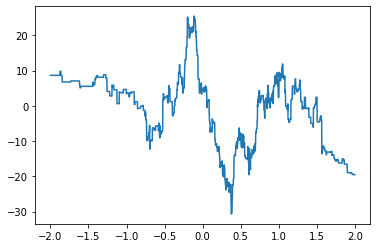

In [401]:
plt.plot(thred_list, reward_list)

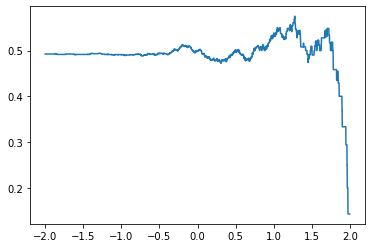

In [402]:
plt.plot(thred_list, win_list)

## Sharpe Ratio

In [403]:
thred = 1
sr = dist_hist.mean(axis=2) / dist_hist.std(axis=2)
actions = np.where(sr > thred, 1, 0)
epi_rewards = (reward_hist * actions)
print('勝率:', len(epi_rewards[epi_rewards > 0]) 
                      / len(epi_rewards[epi_rewards != 0]))
print('利益:', epi_rewards[epi_rewards > 0].sum())
print('損失:', epi_rewards[epi_rewards < 0].sum())

勝率: 0.4807121661721068
利益: 190.15721692238003
損失: -212.82379840966314


In [404]:
thred_list = []
reward_list = []
win_list = []
sr = dist_hist.mean(axis=2) / dist_hist.std(axis=2)

for thred in np.arange(-10, 10, 0.01):
    actions = np.where(sr > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()
    win_list.append(sum(reward_hist * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    reward_list.append(epi_rewards)

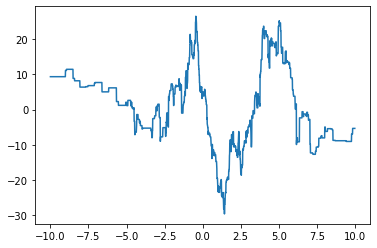

In [405]:
plt.plot(thred_list, reward_list)

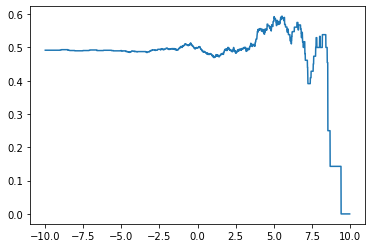

In [406]:
plt.plot(thred_list, win_list)

## distの最小値がthred以下の時

In [407]:
thred_list = []
reward_list = []
win_list = []
minv = dist_hist.min(axis=2)

for thred in np.arange(-0.05, 0.05, 0.00005):
    actions = np.where(minv > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()
    win_list.append(sum(reward_hist * actions > 0) / sum(actions > 0))

    thred_list.append(thred)
    reward_list.append(epi_rewards)

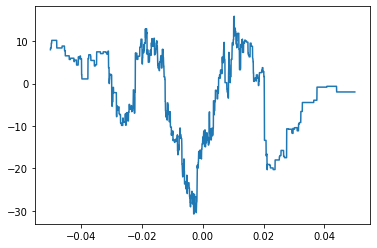

In [408]:
plt.plot(thred_list, reward_list)

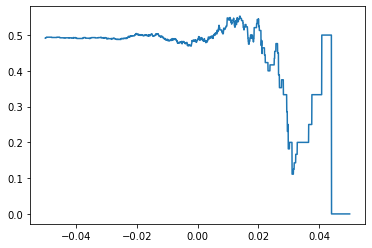

In [409]:
plt.plot(thred_list, win_list)

# VaR

In [410]:
thred_list = []
reward_list = []
minv = dist_hist.min(axis=2)

for thred in np.arange(-0.1, 0.1, 0.00001):
    actions = np.where(minv > thred, 1, 0)
    epi_rewards = (reward_hist * actions).sum()

    thred_list.append(thred)
    reward_list.append(epi_rewards)

In [411]:
# dist_hist = []
# reward_hist = []
# action_hist = []
# epi_rewards = 0

# for batch in val_dl:
#     state = batch.Text1[0].to(trainer.device)
#     reward = batch.Label.to(trainer.device)
    
#     with torch.no_grad():
#         dist = trainer.model(state) * trainer.quantile_weight
#         dist_hist.append(dist.cpu().detach().numpy())
#         reward_hist.append(reward.cpu().detach().numpy()[0])
#         dist = dist[0][1].cpu().detach().numpy()
#         sr = dist.mean() / dist.std()
#         action = 0
#         if sr > 0.3:
#             action = 1
            
#         action_hist.append(action)
        

#     epi_rewards += (action * reward).detach().cpu().numpy().sum()

# print(' '*20, 'train_reward: ', epi_rewards)
# dist_hist = np.array(dist_hist).reshape(-1, 2, 51)
# action_hist = np.array(action_hist)

# プロット

In [ ]:
np.arange()

i =  0 実際: [-1.9789648] 平均: 0.06490963 Sharpe Ratio: 12.863
i =  1 実際: [-2.6118877] 平均: 0.033842232 Sharpe Ratio: 7.581
i =  2 実際: [-0.4928965] 平均: -0.0048285895 Sharpe Ratio: -0.98
i =  3 実際: [-1.5879953] 平均: 0.04175848 Sharpe Ratio: 9.567
i =  4 実際: [2.931162] 平均: 0.020003432 Sharpe Ratio: 3.49
i =  5 実際: [-2.243636] 平均: 0.013068566 Sharpe Ratio: 2.237
i =  6 実際: [-0.2515165] 平均: 0.008664485 Sharpe Ratio: 1.517
i =  7 実際: [0.9196084] 平均: 0.0036748156 Sharpe Ratio: 0.768
i =  8 実際: [-3.3803644] 平均: 0.0099641 Sharpe Ratio: 1.996
i =  9 実際: [6.727159] 平均: -0.013834447 Sharpe Ratio: -2.613
i =  10 実際: [0.02931692] 平均: 0.026518952 Sharpe Ratio: 6.876
i =  11 実際: [-2.8575616] 平均: 0.0024156626 Sharpe Ratio: 0.47
i =  12 実際: [3.8014784] 平均: -0.02537199 Sharpe Ratio: -4.07
i =  13 実際: [0.02906554] 平均: 0.010760185 Sharpe Ratio: 1.993
i =  14 実際: [4.60555] 平均: 0.023689207 Sharpe Ratio: 5.646
i =  15 実際: [1.9305556] 平均: 0.0033326764 Sharpe Ratio: 0.547
i =  16 実際: [-0.4769042] 平均: 0.0059476513 S

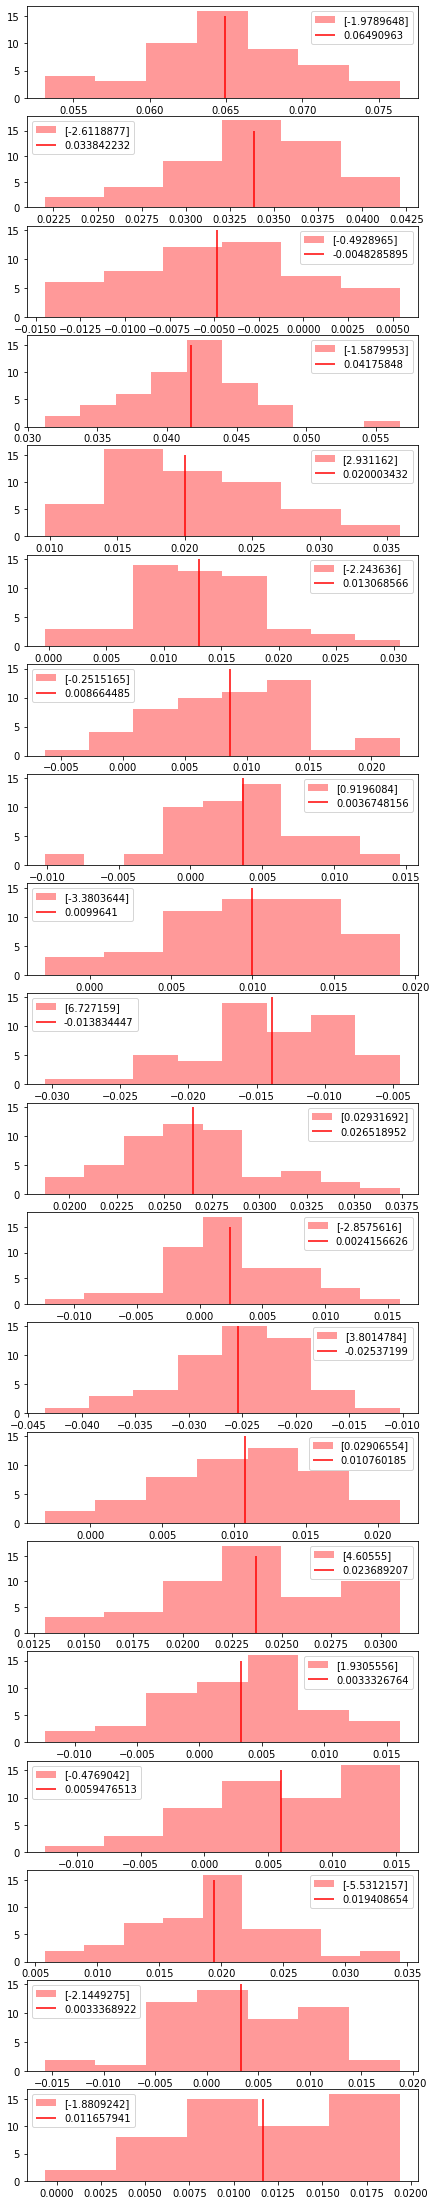

In [346]:
start = 0
N = 20
fig, ax = plt.subplots((N-start), 1, figsize=(7, (N-start)*2));
for i in range(start, N):    
    # 分布
    if args.num_actions >= 2:
        sns.distplot(dist_hist[i][1], color='red', kde=False, ax=ax[i - start], label=str(reward_hist[i]))
        dist = dist_hist[i][1]
    else:
        sns.distplot(dist_hist[i][0], color='red', kde=False, ax=ax[i - start], label=str(reward_hist[i]))
        dist = dist_hist[i][0]
    
    
    # 期待値
    mean = np.round(dist.mean(), 10)
    ax[i - start].vlines(mean, ymin=0, ymax=15, color='red', label=str(mean))
    
    
    # sharpe ratio
    sr = np.round(dist.mean() / dist.std(), 3)
    
    

    print('i = ', i,
              '実際:', reward_hist[i],
              '平均:', mean,
              'Sharpe Ratio:', sr)
    
    ax[i-start].legend()
#     ax[i-start].set_xlim(-0.05, 0.05)


In [314]:
dist

array([-0.00067257,  0.00540369,  0.00551404,  0.00424944,  0.00121795,
        0.01256673,  0.00813147,  0.01109483,  0.00475499,  0.0075354 ,
        0.011066  ,  0.01272733,  0.0043279 ,  0.00632416,  0.01040746,
        0.01093425,  0.00886731,  0.01598813,  0.01691841,  0.01255493,
        0.01687411,  0.01152084,  0.00710479,  0.01500784,  0.00810775,
        0.01196508,  0.01351751,  0.00897489,  0.00905955,  0.01116187,
        0.00705023,  0.01573201,  0.00895506,  0.01758984,  0.01287709,
        0.01623283,  0.01917313,  0.00834115,  0.01558648,  0.01229084,
        0.01068139,  0.01697928,  0.00790157,  0.01890101,  0.01646123,
        0.01933349,  0.01866065,  0.01404079,  0.01648455,  0.01869784,
        0.01937846], dtype=float32)